In [39]:
import pandas as pd
import glob
import os

# dataset path
data_folder = r"C:\Users\YASHU\Documents\Unified\Projects-20240722T093004Z-001\Projects\fraud_detection\fraud_detection\dataset\data" + os.sep
pkl_files = sorted(glob.glob(data_folder + "*.pkl"))

data_list = [pd.read_pickle(file) for file in pkl_files]
data = pd.concat(data_list, ignore_index=True)
data.to_csv('total.csv')

print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   TRANSACTION_ID     int64         
 1   TX_DATETIME        datetime64[ns]
 2   CUSTOMER_ID        object        
 3   TERMINAL_ID        object        
 4   TX_AMOUNT          float64       
 5   TX_TIME_SECONDS    object        
 6   TX_TIME_DAYS       object        
 7   TX_FRAUD           int64         
 8   TX_FRAUD_SCENARIO  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 120.4+ MB
None
   TRANSACTION_ID         TX_DATETIME CUSTOMER_ID TERMINAL_ID  TX_AMOUNT  \
0               0 2018-04-01 00:00:31         596        3156      57.16   
1               1 2018-04-01 00:02:10        4961        3412      81.51   
2               2 2018-04-01 00:07:56           2        1365     146.00   
3               3 2018-04-01 00:09:29        4128        8737      

#### Data Preproccessing

In [40]:
data['TX_DATETIME'] = pd.to_datetime(data['TX_DATETIME'])
data = data.sort_values(by='TX_DATETIME')

In [41]:
data.fillna(0, inplace=True)  # Fill NaNs with zeros (adjust based on data)


#### Scenario 1:

In [42]:
data['high_amount_fraud'] = (data['TX_AMOUNT'] > 220).astype(int)

In [53]:
print(sum(data['high_amount_fraud']))

3258


#### Scenario 2:

In [43]:
# Identify fraudulent terminals
fraud_terminals = data[data['TX_FRAUD'] == 1].groupby('TERMINAL_ID')['TX_DATETIME'].transform(
    lambda x: (x + pd.Timedelta(days=28))
)
data['terminal_fraud'] = data['TERMINAL_ID'].isin(fraud_terminals.index).astype(int)

# Add a rolling fraud count feature
data['terminal_fraud_count'] = data.groupby('TERMINAL_ID')['TX_FRAUD'].transform(lambda x: x.rolling(28, min_periods=1).sum())


In [52]:
print(sum(data['terminal_fraud_count']))

378903.0


#### Scenario 3:

In [81]:
# Customer rolling mean and deviation
data['customer_mean_spend'] = data.groupby('CUSTOMER_ID')['TX_AMOUNT'].transform(lambda x: x.rolling(14, min_periods=1).mean())
data['customer_spend_deviation'] = abs(data['TX_AMOUNT'] - data['customer_mean_spend'])


In [82]:
print(data['customer_mean_spend'].isnull().sum())

0


#### Dataset Split

In [83]:
# Spliting the data into train (first 146 days) and test (last 37 days)
train_data = data[data['TX_DATETIME'] < data['TX_DATETIME'].quantile(0.8)]
test_data = data[data['TX_DATETIME'] >= data['TX_DATETIME'].quantile(0.8)]

# Features and labels
feature_columns = ['TX_AMOUNT', 'high_amount_fraud', 'terminal_fraud', 'terminal_fraud_count', 
                   'customer_mean_spend', 'customer_spend_deviation']
X_train = train_data[feature_columns]
y_train = train_data['TX_FRAUD']

X_test = test_data[feature_columns]
y_test = test_data['TX_FRAUD']




#### Model

In [112]:
from xgboost import XGBClassifier

# Initialize and train the model
model = XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

#### Classification Results

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    521923
           1       0.69      0.63      0.66      4324

    accuracy                           0.99    526247
   macro avg       0.84      0.81      0.83    526247
weighted avg       0.99      0.99      0.99    526247

AUC-ROC: 0.995684992754938


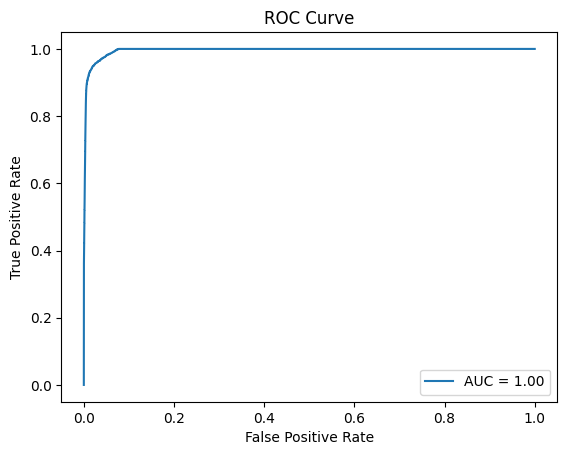

In [113]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predictions and probabilities
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Classification report
print(classification_report(y_test, y_pred))

# AUC-ROC score
print("AUC-ROC:", roc_auc_score(y_test, y_prob))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label="AUC = {:.2f}".format(roc_auc_score(y_test, y_prob)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
